In [111]:
import pandas as pd
import csv
import re
import time
import string
import numpy as np
from sklearn import preprocessing, model_selection, naive_bayes, svm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [112]:
!pip install pyspark

In [113]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Create SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
data = spark.read.csv('instagram-comments.csv', header=True, sep=";")
data.show(5)

+--------------------+--------+
|             Comment|   SCORE|
+--------------------+--------+
|Rebagliati 4 cham...|  Neutro|
|        Fifa = Mafia|Negativo|
|Es que argentina ...|Negativo|
|Bueno menos pelea...|Positivo|
|jairrios_98 al co...|Positivo|
+--------------------+--------+
only showing top 5 rows



In [114]:
data.printSchema()

root
 |-- Comment: string (nullable = true)
 |-- SCORE: string (nullable = true)



In [115]:
df = data.toPandas()
print(df)

                                              Comment     SCORE
0                 Rebagliati 4 chambas quien como ese    Neutro
1                                        Fifa = Mafia  Negativo
2   Es que argentina 🇦🇷 es todo ellos manejan todo...  Negativo
3                   Bueno menos pelea para clasificar  Positivo
4   jairrios_98 al contrario, más pelea porque est...  Positivo
..                                                ...       ...
95  leomar2806 Planteala bien nomás y te quedará b...    Neutro
96                                             NOOOOO  Negativo
97  La Mafia tiene una característica: SON CARA DE...  Negativo
98                                 Un arroz con mango  Negativo
99                                No estoy de acuerdo  Negativo

[100 rows x 2 columns]


In [116]:
def clean_text(Comment):
  text = re.sub(r'^RT[\s]+', '', Comment)
  text = re.sub(r'https?:\/\/.*[\r\n]*', '', Comment)
  text = re.sub(r'#', '', Comment)
  text = re.sub(r'@[A-Za-z0-9]+', '', Comment)
  return Comment

In [117]:
df['clean_text'] = df['Comment'].apply(str)

In [118]:
df['clean_text'] = df['clean_text'].apply(clean_text)

In [119]:
df['Comment']

0                   Rebagliati 4 chambas quien como ese
1                                          Fifa = Mafia
2     Es que argentina 🇦🇷 es todo ellos manejan todo...
3                     Bueno menos pelea para clasificar
4     jairrios_98 al contrario, más pelea porque est...
                            ...                        
95    leomar2806 Planteala bien nomás y te quedará b...
96                                               NOOOOO
97    La Mafia tiene una característica: SON CARA DE...
98                                   Un arroz con mango
99                                  No estoy de acuerdo
Name: Comment, Length: 100, dtype: object

In [120]:
df

,Comment,SCORE,clean_text
0,Rebagliati 4 chambas quien como ese,Neutro,Rebagliati 4 chambas quien como ese
1,Fifa = Mafia,Negativo,Fifa = Mafia
2,Es que argentina 🇦🇷 es todo ellos manejan todo...,Negativo,Es que argentina 🇦🇷 es todo ellos manejan todo...
3,Bueno menos pelea para clasificar,Positivo,Bueno menos pelea para clasificar
4,"jairrios_98 al contrario, más pelea porque est...",Positivo,"jairrios_98 al contrario, más pelea porque est..."
...,...,...,...
95,leomar2806 Planteala bien nomás y te quedará b...,Neutro,leomar2806 Planteala bien nomás y te quedará b...
96,NOOOOO,Negativo,NOOOOO
97,La Mafia tiene una característica: SON CARA DE...,Negativo,La Mafia tiene una característica: SON CARA DE...
98,Un arroz con mango,Negativo,Un arroz con mango


Counter({'Negativo': 57, 'Neutro': 40, 'Positivo': 3})


<Axes: xlabel='SCORE', ylabel='count'>

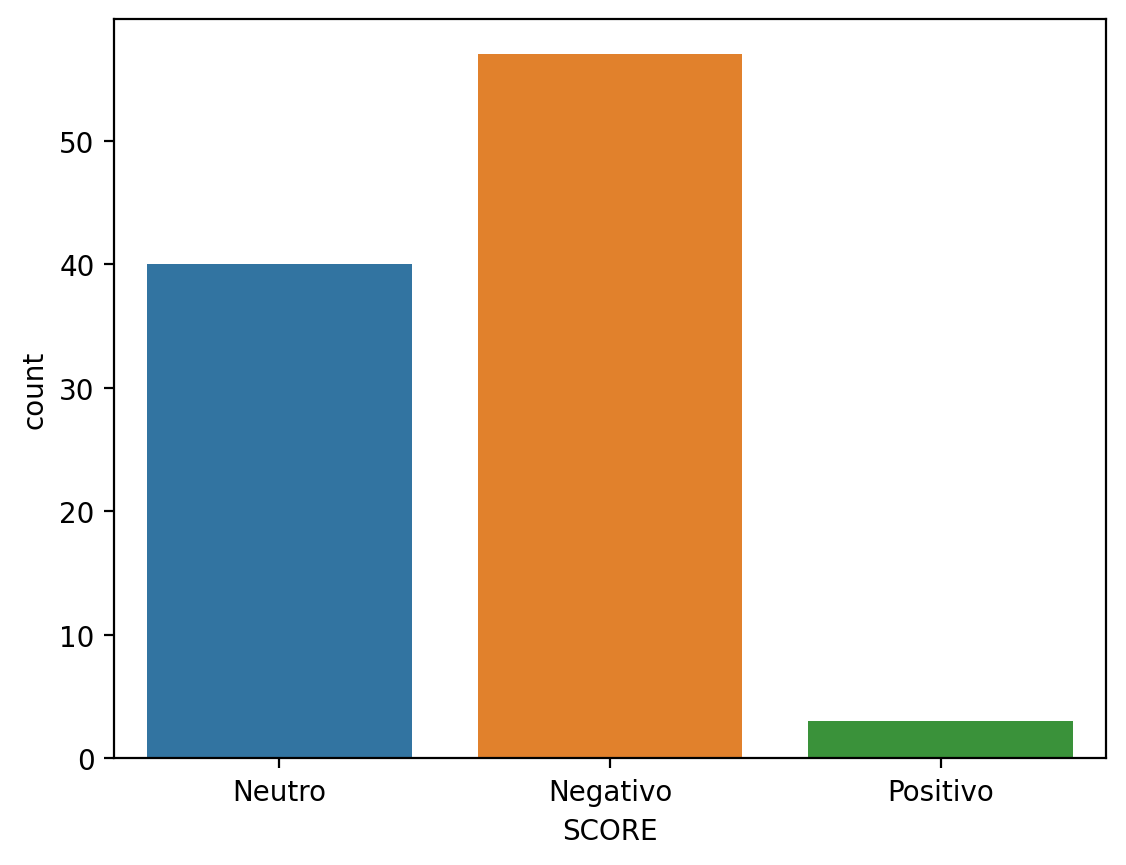

In [121]:
x = df.Comment
y = df.SCORE

from collections import Counter

print(Counter(y))
sns.countplot(x=y)

In [122]:
df['SCORE2'] = df.SCORE

In [123]:
# replace label pada dataset
df.SCORE.replace("Positivo", 0 , inplace = True)
df.SCORE.replace("Negativo", 1 , inplace = True)
df.SCORE.replace("Neutro", 2 , inplace = True)
df.head(10)

,Comment,SCORE,clean_text,SCORE2
0,Rebagliati 4 chambas quien como ese,2,Rebagliati 4 chambas quien como ese,Neutro
1,Fifa = Mafia,1,Fifa = Mafia,Negativo
2,Es que argentina 🇦🇷 es todo ellos manejan todo...,1,Es que argentina 🇦🇷 es todo ellos manejan todo...,Negativo
3,Bueno menos pelea para clasificar,0,Bueno menos pelea para clasificar,Positivo
4,"jairrios_98 al contrario, más pelea porque est...",0,"jairrios_98 al contrario, más pelea porque est...",Positivo
5,"El campeonato mundial se fue al tacho,no tien...",1,"El campeonato mundial se fue al tacho,no tien...",Negativo
6,Desde hoy Paraguay se convierte en el nuevo pa...,2,Desde hoy Paraguay se convierte en el nuevo pa...,Neutro
7,Se clasifican por organizar un partido?? Qué d...,1,Se clasifican por organizar un partido?? Qué d...,Negativo
8,"Esta Paraguay metida en este lio, debido a que...",1,"Esta Paraguay metida en este lio, debido a que...",Negativo
9,"Al menos, por lo menos. La final debe ser en e...",0,"Al menos, por lo menos. La final debe ser en e...",Positivo


In [125]:
dfNew = df[['clean_text','SCORE']]
dfNew.head()

,clean_text,SCORE
0,Rebagliati 4 chambas quien como ese,2
1,Fifa = Mafia,1
2,Es que argentina 🇦🇷 es todo ellos manejan todo...,1
3,Bueno menos pelea para clasificar,0
4,"jairrios_98 al contrario, más pelea porque est...",0


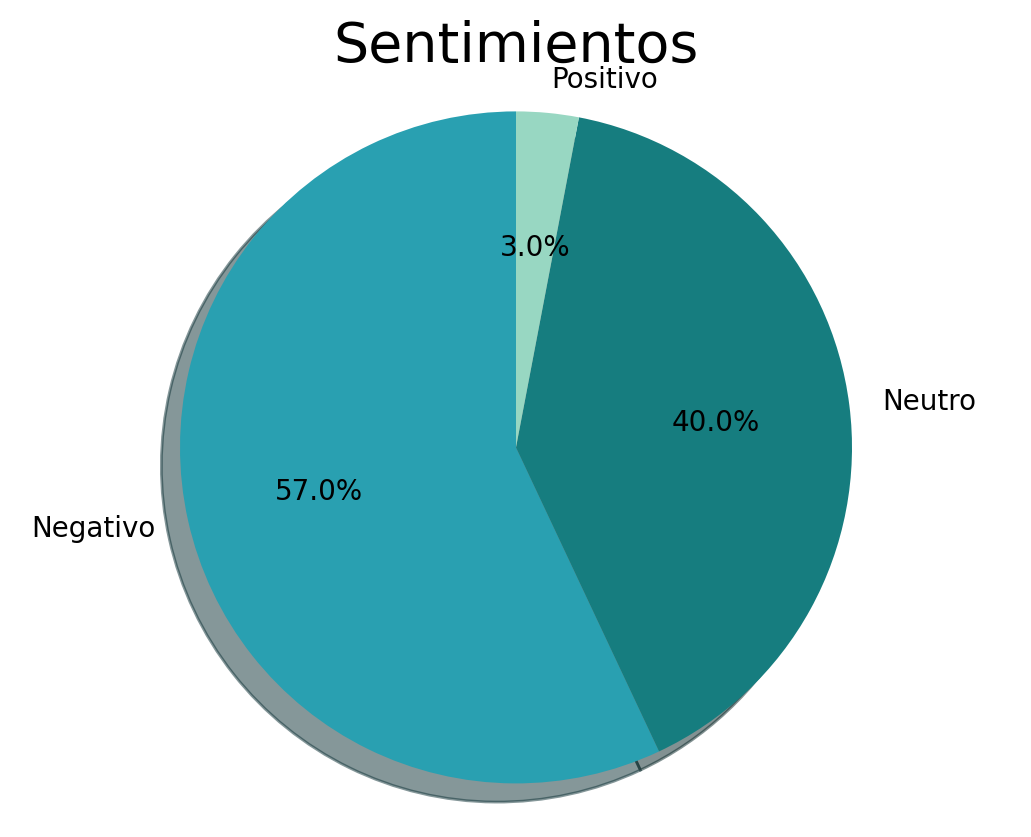

In [126]:
import matplotlib.pyplot as plt
labels = 'Negativo', 'Neutro', 'Positivo'
colors = ['#29A0B1','#167D7F','#98D7C2']
plt.pie(dfNew['SCORE'].value_counts(), labels = labels, colors = colors,
        autopct = '%1.1f%%', shadow = True, startangle = 90)
plt.title('Sentimientos', fontsize = 20)
plt.axis('equal')
plt.show()

In [127]:
# Asignación aleatoria de datos de entrenamiento y prueba
import numpy as np
index = df.index
df['random_number'] = np.random.randn(len(index))
train = df[df['random_number'] <= 0.8]
test = df[df['random_number'] > 0.8]

In [135]:
# Conteo de palabras
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
train_matrix = vectorizer.fit_transform(train['clean_text'])
test_matrix = vectorizer.transform(test['clean_text'])

In [129]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [130]:
X_train = train_matrix
X_test = test_matrix
y_train = train['SCORE']
y_test = test['SCORE']

In [131]:
lr.fit(X_train,y_train)

LogisticRegression()

In [132]:
predictions = lr.predict(X_test)

In [133]:
# find accuracy, precision, recall:
from sklearn.metrics import confusion_matrix,classification_report
new = np.asarray(y_test)
confusion_matrix(predictions,y_test)

array([[10,  1],
       [ 3,  4]])

In [134]:
print(classification_report(predictions, y_test))

              precision    recall  f1-score   support

           1       0.77      0.91      0.83        11
           2       0.80      0.57      0.67         7

    accuracy                           0.78        18
   macro avg       0.78      0.74      0.75        18
weighted avg       0.78      0.78      0.77        18

